In [6]:
import numpy as np 
import pandas as pd
import os
print(os.listdir("../input/intel-mobileodt-cervical-cancer-screening"))

['sample_submission.csv', 'sample_submission_stg2.csv', 'additional_Type_3_v2', 'test_stg2.7z', 'fixed_labels_v2.csv', 'solution_stg1_release.csv', 'additional_Type_1_v2', 'test_stg2_7z_password.txt', 'additional_Type_2_v2', 'test', 'train', 'removed_files.csv']


In [7]:
import glob
import tensorflow as tf

from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.model_selection import train_test_split
from collections import Counter

import cv2
from concurrent import futures
import threading

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

import datetime

In [1]:
#getting the total number of images in the training set

base_dir = '../input/intel-mobileodt-cervical-cancer-screening'

train_dir = os.path.join(base_dir,'train', 'train')

type1_dir = os.path.join(base_dir,'Type_1')
type2_dir = os.path.join(base_dir,'Type_2')
type3_dir = os.path.join(base_dir,'Type_3')

type1_files = glob.glob(type1_dir+'/*.jpg')
type2_files = glob.glob(type2_dir+'/*.jpg')
type3_files = glob.glob(type3_dir+'/*.jpg')

added_type1_files  =  glob.glob(os.path.join(base_dir, "additional_Type_1_v2", "Type_1")+'/*.jpg')
added_type2_files  =  glob.glob(os.path.join(base_dir, "additional_Type_2_v2", "Type_2")+'/*.jpg')
added_type3_files  =  glob.glob(os.path.join(base_dir, "additional_Type_3_v2", "Type_3")+'/*.jpg')

type1_files = type1_files + added_type1_files
type2_files = type2_files + added_type2_files
type3_files = type3_files + added_type3_files

print('Number of images in a train set of type 1: ', len(type1_files))
print('Number of images in a train set of type 2: ', len(type2_files))
print('Number of images in a train set of type 3: ', len(type3_files))
print('Total number of images in a train set: ', sum([len(type1_files), len(type2_files), len(type3_files)]))

Number of images in a train set of type 1:  1191
Number of images in a train set of type 2:  3567
Number of images in a train set of type 3:  1976
Total number of images in a train set:  6734


In [9]:
#Building a dataframe mapping images and Cancer type

files_df = pd.DataFrame({
    'filename': type1_files + type2_files + type3_files,
    'label': ['Type_1'] * len(type1_files) + ['Type_2'] * len(type2_files) + ['Type_3'] * len(type3_files)
})

files_df

,filename,label
0,../input/intel-mobileodt-cervical-cancer-scree...,Type_1
1,../input/intel-mobileodt-cervical-cancer-scree...,Type_1
2,../input/intel-mobileodt-cervical-cancer-scree...,Type_1
3,../input/intel-mobileodt-cervical-cancer-scree...,Type_1
4,../input/intel-mobileodt-cervical-cancer-scree...,Type_1
...,...,...
6729,../input/intel-mobileodt-cervical-cancer-scree...,Type_3
6730,../input/intel-mobileodt-cervical-cancer-scree...,Type_3
6731,../input/intel-mobileodt-cervical-cancer-scree...,Type_3
6732,../input/intel-mobileodt-cervical-cancer-scree...,Type_3


In [10]:
#Shuffle data

random_state = 42

files_df = files_df.sample(frac=1, random_state=random_state)

files_df

,filename,label
381,../input/intel-mobileodt-cervical-cancer-scree...,Type_1
4696,../input/intel-mobileodt-cervical-cancer-scree...,Type_2
5577,../input/intel-mobileodt-cervical-cancer-scree...,Type_3
2018,../input/intel-mobileodt-cervical-cancer-scree...,Type_2
2185,../input/intel-mobileodt-cervical-cancer-scree...,Type_2
...,...,...
3772,../input/intel-mobileodt-cervical-cancer-scree...,Type_2
5191,../input/intel-mobileodt-cervical-cancer-scree...,Type_3
5226,../input/intel-mobileodt-cervical-cancer-scree...,Type_3
5390,../input/intel-mobileodt-cervical-cancer-scree...,Type_3


In [3]:
files_df.describe()

,filename,label
count,6734,6734
unique,6734,3
top,../input/intel-mobileodt-cervical-cancer-scree...,Type_2
freq,1,3567


In [12]:
#Check for duplicates
len(files_df[files_df.duplicated()])

0

In [13]:
#Get count of each type 
type_count = pd.DataFrame(files_df['label'].value_counts()).rename(columns= {'label': 'Num_Values'})
type_count

,count
label,
Type_2,3567
Type_3,1976
Type_1,1191


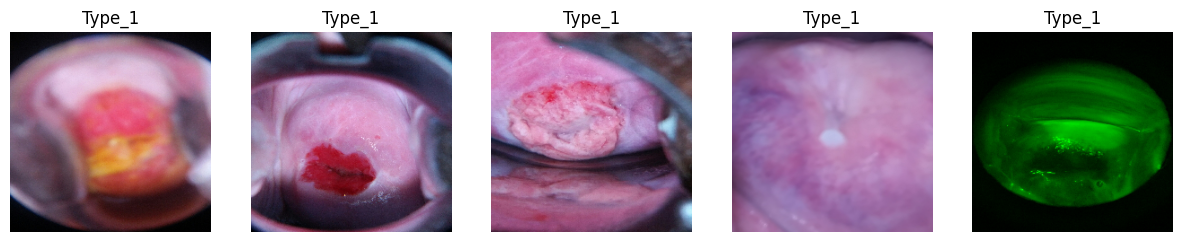

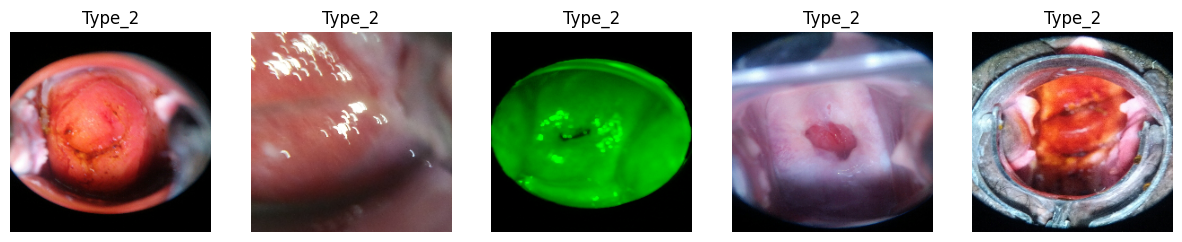

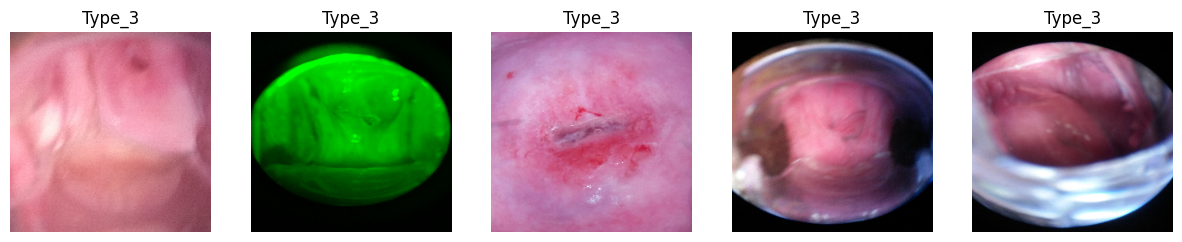

In [14]:
#Display sample images of types
for label in ('Type_1', 'Type_2', 'Type_3'):
    filepaths = files_df[files_df['label']==label]['filename'].values[:5]
    fig = plt.figure(figsize= (15, 6))
    for i, path in enumerate(filepaths):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = cv2.resize(img, (224, 224))
        fig.add_subplot(1, 5, i+1)
        plt.imshow(img)
        plt.subplots_adjust(hspace=0.5)
        plt.axis(False)
        plt.title(label)

In [15]:
#Split training,val and test set : 70:15:15

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, 
                                                                      random_state=random_state)

test_files, val_files, test_labels, val_labels = train_test_split(test_files,
                                                                  test_labels, 
                                                                  test_size=0.5, 
                                                                  random_state=random_state)


print('Number of images in train set: ', train_files.shape)
print('Number of images in validation set: ', val_files.shape)
print('Number of images in test set: ', test_files.shape, '\n')

print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

Number of images in train set:  (4713,)
Number of images in validation set:  (1011,)
Number of images in test set:  (1010,) 

Train: Counter({'Type_2': 2532, 'Type_3': 1339, 'Type_1': 842}) 
Val: Counter({'Type_2': 529, 'Type_3': 321, 'Type_1': 161}) 
Test: Counter({'Type_2': 506, 'Type_3': 316, 'Type_1': 188})


In [16]:
def load_images(files, labels):
    features = []
    correct_labels = []
    bad_images = 0
    
    for i in range(len(files)):
        try:
            img = cv2.imread(files[i])
            # Resize images to 299x299 for InceptionV3
            resized_img = cv2.resize(img, (299, 299))
            
            features.append(np.array(resized_img))
            correct_labels.append(labels[i])
                   
        except Exception as e:
            bad_images += 1
            print('Encountered bad image:', e)
    
    print('Bad images encountered:', bad_images)
    return np.array(features), np.array(correct_labels)

In [17]:
#Load training and evaluation data
train_features, train_labels = load_images(train_files, train_labels)
print('Train images loaded')
val_features, val_labels = load_images(val_files, val_labels)
print('Validation images loaded')
test_features, test_labels = load_images(test_files, test_labels)
print('test images loaded')

Premature end of JPEG file


Encountered bad image: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Encountered bad image: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Bad images encountered: 2
Train images loaded
Bad images encountered: 0
Validation images loaded


Premature end of JPEG file


Encountered bad image: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Bad images encountered: 1
test images loaded


In [18]:
# check lengths of training and evaluation  sets
len(train_features), len(train_labels), len(val_features), len(val_labels), len(test_features), len(test_labels) 

(4711, 4711, 1011, 1011, 1009, 1009)

In [19]:
BATCH_SIZE = 32
NUM_CLASSES = 3
EPOCHS = 20
INPUT_SHAPE = (160, 160, 3)

In [20]:
#encode train+val sets text categories with labels
le = LabelEncoder()
le.fit(train_labels)

train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

train_labels_1hotenc = tf.keras.utils.to_categorical(train_labels_enc, num_classes=NUM_CLASSES)
val_labels_1hotenc = tf.keras.utils.to_categorical(val_labels_enc, num_classes=NUM_CLASSES)

print(train_labels[:6], train_labels_enc[:6])
print(train_labels[:6], train_labels_1hotenc[:6])

['Type_2' 'Type_2' 'Type_2' 'Type_3' 'Type_2' 'Type_1'] [1 1 1 2 1 0]
['Type_2' 'Type_2' 'Type_2' 'Type_3' 'Type_2' 'Type_1'] [[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [21]:
le = LabelEncoder()
le.fit(test_labels)

test_labels_enc = le.transform(test_labels)

test_labels_1hotenc = tf.keras.utils.to_categorical(test_labels_enc, num_classes=NUM_CLASSES)


print(test_labels[:6], test_labels_enc[:6])
print(test_labels[:6], test_labels_1hotenc[:6])

['Type_3' 'Type_3' 'Type_2' 'Type_2' 'Type_2' 'Type_1'] [2 2 1 1 1 0]
['Type_3' 'Type_3' 'Type_2' 'Type_2' 'Type_2' 'Type_1'] [[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [22]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

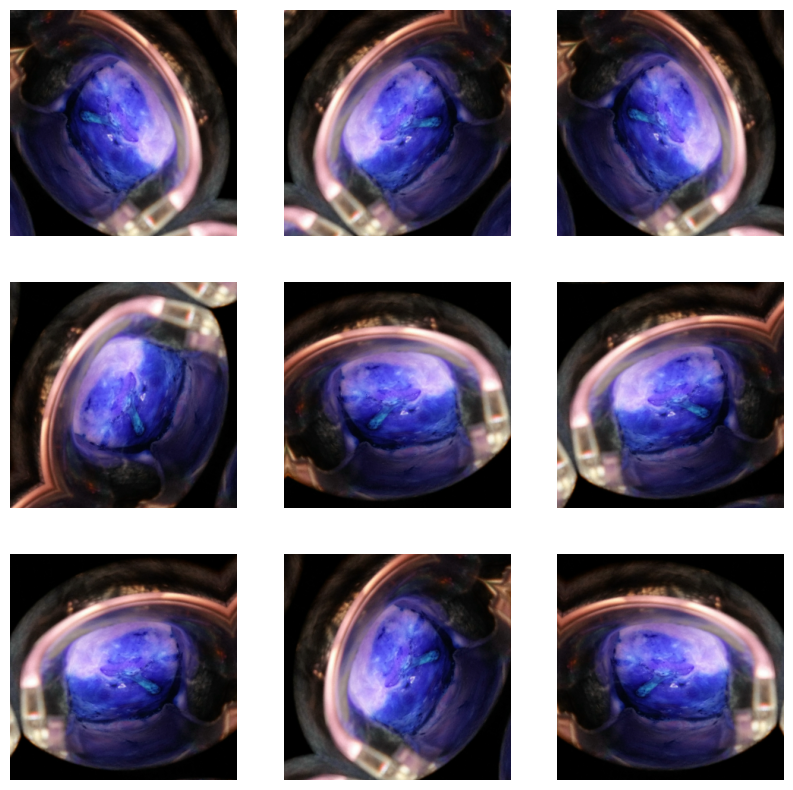

In [23]:
plt.figure(figsize=(10, 10))
first_image = train_features[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [24]:
# Load the InceptionV3 model as the base model
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(299, 299, 3)  
)

# Freeze the base model layers
base_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
# Define the input layer with the correct input shape for InceptionV3
inputs = tf.keras.Input(shape=(299, 299, 3))  # Update input shape

# Apply data augmentation to the input
x = data_augmentation(inputs)

# Rescale pixel values using InceptionV3's preprocessing function
preprocess_input = tf.keras.applications.inception_v3.preprocess_input
x = preprocess_input(x)

# Pass the augmented and preprocessed input through the base model
x = base_model(x, training=False)

# Add layers for classification
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Global average pooling
x = tf.keras.layers.Dropout(0.2)(x)  # Dropout layer for regularization
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)  # Output layer for 3 classes

# Create the final model
model = tf.keras.Model(inputs, outputs)

In [26]:
# Compile the model
learning_rate = 1e-4

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,808,931 (83.19 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [28]:
# Train the model
history = model.fit(x=train_features, 
                    y=train_labels_1hotenc, 
                    batch_size=BATCH_SIZE,
                    epochs=50, 
                    validation_data=(val_features, val_labels_1hotenc),
                    verbose=1)

Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - accuracy: 0.4633 - loss: 1.0974 - val_accuracy: 0.5321 - val_loss: 1.0106
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 24s 160ms/step - accuracy: 0.5086 - loss: 1.0229 - val_accuracy: 0.5312 - val_loss: 0.9870
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 24s 163ms/step - accuracy: 0.5151 - loss: 1.0126 - val_accuracy: 0.5321 - val_loss: 1.0019
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 24s 164ms/step - accuracy: 0.5092 - loss: 1.0105 - val_accuracy: 0.5292 - val_loss: 0.9777
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 24s 166ms/step - accuracy: 0.5317 - loss: 0.9837 - val_accuracy: 0.5232 - val_loss: 0.9648
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 25s 166ms/step - accuracy: 0.5211 - loss: 0.9881 - val_accuracy: 0.5124 - val_loss: 0.9587
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 25s 168ms/step - accuracy: 0.5187 - loss: 0.9831 - val_accuracy: 0.5292 - val_loss: 0.9595
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 25s 168ms/step - accuracy: 0.5404 - loss: 0

In [2]:
model.save("/kaggle/working/final_model.keras")

In [3]:
def learning_performance_chart(title='Learning Perfomance', history=history):
    #plots a chart showing the change in accuracy and loss function over epochs
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle(title, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    max_epoch = len(history.history['accuracy'])+1
    epoch_list = list(range(1,max_epoch))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(1, max_epoch, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(1, max_epoch, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

In [4]:
print('InceptionV3 performance on the test set:')
results = model.evaluate(test_features,test_labels_1hotenc, verbose=1)

InceptionV3 performance on the test set:
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 189ms/step - accuracy: 0.7372 - loss: 0.8939


In [5]:
tuning_model_1 = base_model
tuning_model_1.trainable = True

In [6]:
# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in tuning_model_1.layers[:fine_tune_at]:
    layer.trainable = False

In [7]:
# Compile the model
# Use smaller learning rate
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate/10),
              metrics=['accuracy'])

In [13]:
len(model.trainable_variables)

118

In [17]:
# Train the model some more

fine_tune_epochs = 20
total_epochs =  40 + fine_tune_epochs

history_fine = model.fit(x= train_features,
                         y=train_labels_1hotenc, 
                         batch_size=BATCH_SIZE,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(val_features, val_labels_1hotenc),
                         verbose=1)

Epoch 50/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 55s 374ms/step - accuracy: 0.9791 - loss: 0.0711 - val_accuracy: 0.7448 - val_loss: 0.8282
Epoch 51/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 54s 367ms/step - accuracy: 0.9803 - loss: 0.0664 - val_accuracy: 0.7488 - val_loss: 0.8282
Epoch 52/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9827 - loss: 0.0555 - val_accuracy: 0.7547 - val_loss: 0.8266
Epoch 53/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 54s 367ms/step - accuracy: 0.9859 - loss: 0.0520 - val_accuracy: 0.7507 - val_loss: 0.8320
Epoch 54/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9863 - loss: 0.0558 - val_accuracy: 0.7646 - val_loss: 0.8520
Epoch 55/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9852 - loss: 0.0506 - val_accuracy: 0.7587 - val_loss: 0.8400
Epoch 56/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 54s 367ms/step - accuracy: 0.9829 - loss: 0.0532 - val_accuracy: 0.7596 - val_loss: 0.8698
Epoch 57/60
148/148 ━━━━━━━━━━━━━━━━━━━━ 54s 367ms/step - accuracy: 0.9874 -

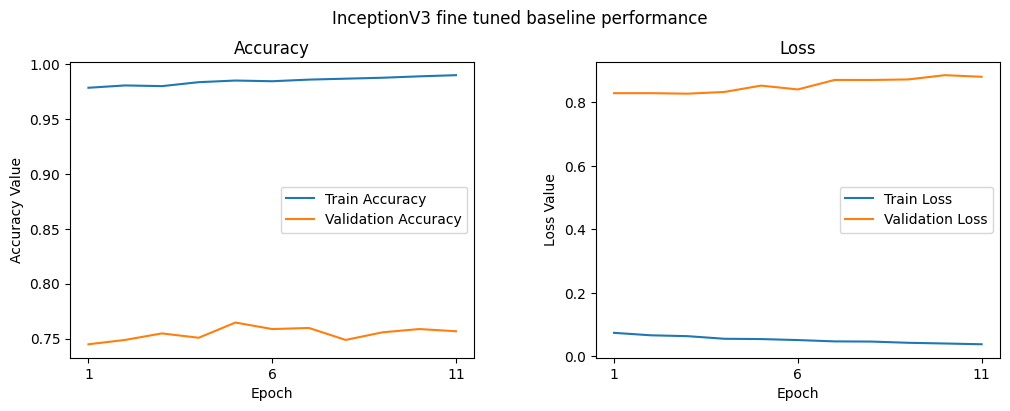

In [18]:
learning_performance_chart(title='InceptionV3 fine tuned baseline performance', history=history_fine)

In [19]:
print('fine tuned InceptionV3 performance on the test set:')
results = model.evaluate(test_features,test_labels_1hotenc, verbose=1)

fine tuned InceptionV3 performance on the test set:
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.7511 - loss: 0.9747


In [20]:
test_dir = os.path.join('../input/intel-mobileodt-cervical-cancer-screening/test/test')

test_files = glob.glob(test_dir+'/*.jpg')

print('Number of images in a test set:', len(test_files))

Number of images in a test set: 512


In [21]:
#sort test files in correct order 
from tkinter import Tcl
test_files = Tcl().call('lsort', '-dict', test_files)
test_files[:5]

('../input/intel-mobileodt-cervical-cancer-screening/test/test/0.jpg',
 '../input/intel-mobileodt-cervical-cancer-screening/test/test/1.jpg',
 '../input/intel-mobileodt-cervical-cancer-screening/test/test/2.jpg',
 '../input/intel-mobileodt-cervical-cancer-screening/test/test/3.jpg',
 '../input/intel-mobileodt-cervical-cancer-screening/test/test/4.jpg')

In [22]:
# Load test images
features = []
bad_images = 0

for i in range(len(test_files)):
    try:
        # Read and resize the images to 299x299 for InceptionV3
        img = cv2.imread(test_files[i])
        resized_img = cv2.resize(img, (299, 299))
        
        features.append(np.array(resized_img))
                   
    except Exception as e:
        bad_images += 1
        print('Encountered bad image:', e)
        
print('Bad images encountered:', bad_images)

# Convert the list to a numpy array for model input
test_images = np.array(features)

Bad images encountered: 0


In [23]:
test_images.shape

(512, 299, 299, 3)

In [24]:
predictions = model.predict(test_images)
predictions[:5]

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step


array([[8.9459550e-03, 9.9071306e-01, 3.4096494e-04],
       [2.9568672e-02, 9.4505268e-01, 2.5378613e-02],
       [9.9989390e-01, 1.0560571e-04, 4.5740023e-07],
       [2.0717554e-02, 8.8534307e-01, 9.3939416e-02],
       [2.8249815e-01, 6.7699677e-01, 4.0505107e-02]], dtype=float32)

In [25]:
from IPython.display import FileLink

# Make sure the file path is correct
file_path = 'final_model.keras'

# Generate a download link
FileLink(file_path)

/kaggle/working/final_model.keras